<a href="https://colab.research.google.com/github/hario27/PositionChecker/blob/master/3%E5%88%86%E8%B6%B3RSI%E3%83%88%E3%83%AC%E3%83%BC%E3%83%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

モジュール読み込み

In [ ]:
!pip install pyti

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyti

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


データ読み込み

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/USDJPY_M3_200001030000_202012042354.csv", sep='\t')
df.columns

Index(['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>',
       '<VOL>', '<SPREAD>'],
      dtype='object')

In [ ]:
df.columns = ["date", "time", "open", "high", "low", "close", "tickvol", "vol", "spread"]
df.columns

Index(['date', 'time', 'open', 'high', 'low', 'close', 'tickvol', 'vol',
       'spread'],
      dtype='object')

目的変数追加

In [ ]:
df["close+1"] = df["close"].shift(-1)
df['diff'] = df['close+1'] - df['close']
df = df[:-1]
df.tail()

,date,time,open,high,low,close,tickvol,vol,spread,close+1,diff
2578899,2020.12.04,23:39:00,104.189,104.190,104.184,104.185,56,0,20,104.189,0.004
2578900,2020.12.04,23:42:00,104.184,104.190,104.183,104.189,67,0,18,104.189,0.000
2578901,2020.12.04,23:45:00,104.189,104.193,104.183,104.189,154,0,17,104.176,-0.013
2578902,2020.12.04,23:48:00,104.186,104.194,104.172,104.176,139,0,16,104.189,0.013
2578903,2020.12.04,23:51:00,104.177,104.192,104.177,104.189,69,0,18,104.178,-0.011


In [ ]:
# 値上がり幅、値下がり幅をシリーズへ切り分け
diff = df["diff"]
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0

In [ ]:
# 上昇したら「1」、下降したら「0」へデータを変換
mask1 = df['diff'] > 0
mask2 = df['diff'] < 0
column_name = 'diff'
df.loc[mask1, column_name] = 1
df.loc[mask2, column_name] = 0
df = df.rename(columns={'diff': 'target'})
del df["close+1"]
df.tail()

,date,time,open,high,low,close,tickvol,vol,spread,target
2578899,2020.12.04,23:39:00,104.189,104.190,104.184,104.185,56,0,20,1.0
2578900,2020.12.04,23:42:00,104.184,104.190,104.183,104.189,67,0,18,0.0
2578901,2020.12.04,23:45:00,104.189,104.193,104.183,104.189,154,0,17,0.0
2578902,2020.12.04,23:48:00,104.186,104.194,104.172,104.176,139,0,16,1.0
2578903,2020.12.04,23:51:00,104.177,104.192,104.177,104.189,69,0,18,0.0


In [ ]:
# 曜日
import datetime
df["date"] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df["dayweek"] = df['date'].dt.dayofweek
df.head()

,date,time,open,high,low,close,tickvol,vol,spread,target,dayweek
0,2000-01-03,00:00:00,102.14,102.15,102.13,102.14,4,0,50,0.0,0
1,2000-01-03,00:09:00,102.12,102.12,102.12,102.12,1,0,50,1.0,0
2,2000-01-03,00:12:00,102.12,102.15,102.12,102.14,7,0,50,1.0,0
3,2000-01-03,00:15:00,102.15,102.17,102.13,102.17,9,0,50,0.0,0
4,2000-01-03,00:18:00,102.16,102.17,102.14,102.15,6,0,50,1.0,0


In [ ]:
# RSIの計算
from pyti.relative_strength_index import relative_strength_index as rsi
period = 14
df["rsi"] = rsi(df['close'].values.tolist(), period).round(1)
df.tail()

,date,time,open,high,low,close,tickvol,vol,spread,target,dayweek,rsi
2578899,2020-12-04,23:39:00,104.189,104.190,104.184,104.185,56,0,20,1.0,4,63.4
2578900,2020-12-04,23:42:00,104.184,104.190,104.183,104.189,67,0,18,0.0,4,64.8
2578901,2020-12-04,23:45:00,104.189,104.193,104.183,104.189,154,0,17,0.0,4,64.8
2578902,2020-12-04,23:48:00,104.186,104.194,104.172,104.176,139,0,16,1.0,4,56.8
2578903,2020-12-04,23:51:00,104.177,104.192,104.177,104.189,69,0,18,0.0,4,61.8


In [ ]:
# MACDの計算
from pyti.moving_average_convergence_divergence import moving_average_convergence_divergence as macd
macd_period = {'long' : 26, 'short' : 12}
sma_period  = 9
df['macd']   = macd(df['close'].values.tolist(), macd_period['short'], macd_period['long'])
df['signal'] = sma(df['macd'].values.tolist(), sma_period)

In [ ]:
# ATR
close = df["close"]
df["takane-yasune"] = df["high"] - df["low"]
df["owarine-takane"] = df["high"] - df["close"].shift(-1)
df["owarine-takane"] = df["owarine-takane"].abs()
df["owarine-yasune"] = df["low"] - df["close"].shift(-1)
df["owarine-yasune"] = df["owarine-yasune"].abs()
df["tr"] = df[["owarine-takane", "owarine-yasune", "owarine-yasune"]].max(axis=1)
df["atr"] = df["tr"].rolling(window=14).mean()
del df["takane-yasune"]
del df["owarine-takane"]
del df["owarine-yasune"]
del df["tr"]
df.tail()


,date,time,open,high,low,close,tickvol,vol,spread,target,dayweek,rsi,macd,signal,atr
2578899,2020-12-04,23:39:00,104.189,104.190,104.184,104.185,56,0,20,1.0,4,63.4,0.007168,0.007192,0.015429
2578900,2020-12-04,23:42:00,104.184,104.190,104.183,104.189,67,0,18,0.0,4,64.8,0.007572,0.006833,0.014929
2578901,2020-12-04,23:45:00,104.189,104.193,104.183,104.189,154,0,17,0.0,4,64.8,0.008206,0.006766,0.015857
2578902,2020-12-04,23:48:00,104.186,104.194,104.172,104.176,139,0,16,1.0,4,56.8,0.007249,0.006801,0.014429
2578903,2020-12-04,23:51:00,104.177,104.192,104.177,104.189,69,0,18,0.0,4,61.8,0.008050,0.007015,NaN


In [ ]:
# 値上がり幅/値下がり幅の単純移動平均（14)を処理
up_sma_14 = up.rolling(window=14, center=False).mean()
down_sma_14 = down.abs().rolling(window=14, center=False).mean()

In [ ]:
# 移動平均線乖離率
close = df["close"]
df["kaii"] = ((close-close.rolling(window=5).mean().round(3)) / close.rolling(window=5).mean().round(3)) * 100000
df["kaii"] = df["kaii"].round()
df.tail()

,date,time,open,high,low,close,tickvol,vol,spread,target,dayweek,rsi,macd,signal,atr,kaii
2578899,2020-12-04,23:39:00,104.189,104.190,104.184,104.185,56,0,20,1.0,4,63.4,0.007168,0.007192,0.015429,6.0
2578900,2020-12-04,23:42:00,104.184,104.190,104.183,104.189,67,0,18,0.0,4,64.8,0.007572,0.006833,0.014929,7.0
2578901,2020-12-04,23:45:00,104.189,104.193,104.183,104.189,154,0,17,0.0,4,64.8,0.008206,0.006766,0.015857,3.0
2578902,2020-12-04,23:48:00,104.186,104.194,104.172,104.176,139,0,16,1.0,4,56.8,0.007249,0.006801,0.014429,-10.0
2578903,2020-12-04,23:51:00,104.177,104.192,104.177,104.189,69,0,18,0.0,4,61.8,0.008050,0.007015,NaN,3.0


In [ ]:
# 移動平均線
close = df["close"]
list = [3,5,8,10,12,15,30,35,40,45,50,60]
for i in list:
  df["ma" + str(i)] = close.rolling(window=i).mean().round(3)
df.tail()

,target,close,tickvol,vol,spread,dayweek,rsi,kaii,band,hour,ma3,ma5,ma8,ma10,ma12,ma15,ma30,ma35,ma40,ma45,ma50,ma60
2578899,1.0,104.185,56,0,20,4,63.4,6.0,0.052,23.0,104.184,104.179,104.170,104.166,104.165,104.166,104.151,104.145,104.144,104.144,104.141,104.136
2578900,0.0,104.189,67,0,18,4,64.8,7.0,0.056,23.0,104.188,104.182,104.175,104.169,104.167,104.168,104.153,104.147,104.145,104.146,104.143,104.137
2578901,0.0,104.189,154,0,17,4,64.8,3.0,0.050,23.0,104.188,104.186,104.179,104.174,104.169,104.169,104.156,104.149,104.146,104.147,104.144,104.139
2578902,1.0,104.176,139,0,16,4,56.8,-10.0,0.020,23.0,104.185,104.186,104.181,104.176,104.171,104.169,104.158,104.151,104.147,104.147,104.146,104.141
2578903,0.0,104.189,69,0,18,4,61.8,3.0,0.042,23.0,104.185,104.186,104.183,104.180,104.175,104.170,104.161,104.153,104.148,104.148,104.147,104.142


In [ ]:
# エンベロープ 1=アップ、0=ダウン
close = df["close"]
ma = close.rolling(window=25).mean().round(3)
print(ma)
uppser_band = ma * (1 + 2 / 100)
lower_band = ma * (1 + -2 / 100)

df['band'] = (df['close'] - uppser_band) + (df['close'] - lower_band)
df.tail(30)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
2578899    104.159
2578900    104.161
2578901    104.164
2578902    104.166
2578903    104.168
Name: close, Length: 2578904, dtype: float64


,date,time,open,high,low,close,tickvol,vol,spread,target,dayweek,rsi,macd,signal,atr,kaii,ma3,ma5,ma8,ma10,ma12,ma15,ma30,ma35,ma40,ma45,ma50,ma60,band
2578874,2020-12-04,22:24:00,104.111,104.120,104.111,104.119,90,0,3,1.0,4,50.4,-0.007433,-0.004301,0.017571,9.0,104.112,104.110,104.110,104.110,104.114,104.120,104.123,104.119,104.115,104.112,104.112,104.113,-0.008
2578875,2020-12-04,22:27:00,104.120,104.128,104.116,104.123,159,0,3,0.0,4,52.1,-0.006751,-0.005379,0.017286,10.0,104.117,104.113,104.111,104.113,104.112,104.118,104.123,104.120,104.116,104.113,104.112,104.114,-0.002
2578876,2020-12-04,22:30:00,104.122,104.126,104.113,104.114,253,0,3,1.0,4,48.2,-0.006482,-0.006191,0.018071,-1.0,104.119,104.115,104.112,104.112,104.111,104.116,104.122,104.121,104.117,104.114,104.112,104.114,-0.022
2578877,2020-12-04,22:33:00,104.115,104.140,104.114,104.131,302,0,3,1.0,4,55.0,-0.004003,-0.006401,0.018786,12.0,104.123,104.119,104.115,104.113,104.114,104.116,104.122,104.122,104.118,104.114,104.113,104.115,0.012
2578878,2020-12-04,22:36:00,104.132,104.151,104.132,104.147,289,0,3,0.0,4,60.2,-0.001041,-0.006021,0.015857,19.0,104.131,104.127,104.119,104.118,104.116,104.116,104.123,104.123,104.119,104.116,104.113,104.115,0.042
2578879,2020-12-04,22:39:00,104.148,104.153,104.141,104.141,141,0,3,1.0,4,57.5,0.000794,-0.005294,0.014143,10.0,104.140,104.131,104.124,104.121,104.118,104.117,104.125,104.124,104.121,104.117,104.114,104.116,0.028
2578880,2020-12-04,22:42:00,104.142,104.155,104.137,104.148,159,0,3,1.0,4,59.8,0.003225,-0.004172,0.014214,12.0,104.145,104.136,104.129,104.125,104.122,104.121,104.126,104.125,104.122,104.118,104.115,104.116,0.040
2578881,2020-12-04,22:45:00,104.147,104.166,104.147,104.159,199,0,3,1.0,4,63.1,0.006232,-0.002616,0.014500,13.0,104.149,104.145,104.135,104.130,104.126,104.123,104.128,104.125,104.124,104.120,104.117,104.116,0.060
2578882,2020-12-04,22:48:00,104.158,104.176,104.157,104.170,246,0,3,1.0,4,66.1,0.009586,-0.000652,0.014929,16.0,104.159,104.153,104.142,104.136,104.131,104.127,104.130,104.127,104.126,104.122,104.118,104.117,0.082
2578883,2020-12-04,22:51:00,104.171,104.180,104.169,104.171,284,0,3,0.0,4,66.4,0.012614,0.001575,0.015500,12.0,104.167,104.158,104.148,104.142,104.137,104.131,104.132,104.128,104.128,104.124,104.120,104.117,0.082


In [ ]:
df["hour"] = df["time"].str.split(pat=":", expand=True)[0].astype("float64")
df.head()

,date,time,open,high,low,close,tickvol,vol,spread,target,dayweek,rsi,macd,signal,atr,kaii,ma3,ma5,ma8,ma10,ma12,ma15,ma30,ma35,ma40,ma45,ma50,ma60,band,hour
0,2000-01-03,00:00:00,102.14,102.15,102.13,102.14,4,0,50,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2000-01-03,00:09:00,102.12,102.12,102.12,102.12,1,0,50,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2000-01-03,00:12:00,102.12,102.15,102.12,102.14,7,0,50,1.0,0,NaN,NaN,NaN,NaN,NaN,102.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2000-01-03,00:15:00,102.15,102.17,102.13,102.17,9,0,50,0.0,0,NaN,NaN,NaN,NaN,NaN,102.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2000-01-03,00:18:00,102.16,102.17,102.14,102.15,6,0,50,1.0,0,NaN,NaN,NaN,NaN,6.0,102.153,102.144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
# 入れ替え及び削除
#df = df.drop(['time', "open", "high", "low", "date"], axis=1)
#df = df.loc[:,['target',"close", "tickvol", "vol", "spread", "dayweek", "rsi", "kaii", "band", "hour"]]
df.tail()

,target,close,tickvol,vol,spread,dayweek,rsi,kaii,band,hour,ma3,ma5,ma8,ma10,ma12,ma15,ma30,ma35,ma40,ma45,ma50,ma60
2578899,1.0,104.185,56,0,20,4,63.4,6.0,0.052,23.0,104.184,104.179,104.170,104.166,104.165,104.166,104.151,104.145,104.144,104.144,104.141,104.136
2578900,0.0,104.189,67,0,18,4,64.8,7.0,0.056,23.0,104.188,104.182,104.175,104.169,104.167,104.168,104.153,104.147,104.145,104.146,104.143,104.137
2578901,0.0,104.189,154,0,17,4,64.8,3.0,0.050,23.0,104.188,104.186,104.179,104.174,104.169,104.169,104.156,104.149,104.146,104.147,104.144,104.139
2578902,1.0,104.176,139,0,16,4,56.8,-10.0,0.020,23.0,104.185,104.186,104.181,104.176,104.171,104.169,104.158,104.151,104.147,104.147,104.146,104.141
2578903,0.0,104.189,69,0,18,4,61.8,3.0,0.042,23.0,104.185,104.186,104.183,104.180,104.175,104.170,104.161,104.153,104.148,104.148,104.147,104.142


In [ ]:
from sklearn.model_selection import train_test_split

data = df.drop("target", axis=1)
target = df["target"]

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1934178, 21)
(644726, 21)
(1934178,)
(644726,)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# 学習データからXGBoost用のデータを生成
dm_train = xgb.DMatrix(X_train, label=y_train)

# パラメータ
param = {
    'objective': 'binary:logistic'
}

model = xgb.train(param, dm_train)

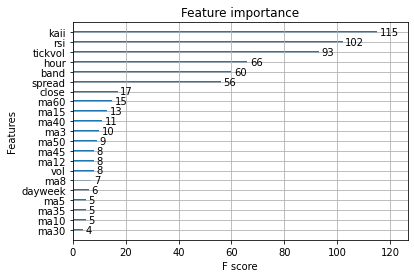

In [ ]:
import matplotlib

# 特徴量の重要度を表示
xgb.plot_importance(model)

In [ ]:
# テスト用のデータを生成
dm_test = xgb.DMatrix(X_test)

# 予測
y_pred = model.predict(dm_test)
# array([2.4190381e-01, 9.9575341e-01, 3.6941297e-04, 9.9836344e-01,
#        ...

# 精度
accuracy = sum(((y_pred > 0.5) & (y_test == 1)) | ((y_pred <= 0.5) & (y_test == 0))) / len(y_pred)
print(accuracy)

0.5583937982957101
